# Netflixを超えていけ！Contextual Banditアルゴリズムを徹底解説！(Part 2)

In [3]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor as GBR, GradientBoostingClassifier as GBC

from pandas import DataFrame
from plotly.offline import iplot, plot
from plotly.graph_objs import Bar, Figure, Layout

In [4]:
from pymab.bandit import GaussianBandit
from pymab.evaluation import DataGenerator, ReplayMethod, DirectMethod, IPSEstimator, DREstimator, MRDREstimator
from pymab.policy import LinUCB, LinTS, LogisticTS
from pymab.sim import BanditSimulator

## Off-Policy Evaluation実験1

### 設定
- アーム数は10, 文脈の次元は20次元のバンディットに対する報酬最適化
- **離散一様分布に従うランダムPolicy**によって集められたデータ数5万のログデータによるOPE
- 用いる評価指標はReplay-MethodとDirect Method（予測モデルには勾配ブースティングを使用）
- 評価指標の性能は各Policyの真の性能と推定された性能の相対誤差によって評価

## Data Generation

In [5]:
n_arms, n_features = 10, 20
gb = GaussianBandit(n_arms=n_arms, n_features=n_features, scale=0.01, noise=0.01, contextual=True)
dg = DataGenerator(policy=LinTS(n_arms=n_arms, n_features=n_features, sigma=1, sample_batch=20, batch_size=1), 
                   bandit=gb,
                   n_rounds=50000, 
                   randomized=True)

In [6]:
data, a, r = dg.generate_data()

## Policy Candidates
- $\pi^{new}$の候補

In [7]:
pols =  [LinUCB(n_arms=n_arms, n_features=n_features, alpha=0.1, batch_size=1),
         LinUCB(n_arms=n_arms, n_features=n_features, alpha=0.01, batch_size=1),
         LinUCB(n_arms=n_arms, n_features=n_features, alpha=1, batch_size=1),
         LinUCB(n_arms=n_arms, n_features=n_features, alpha=10, batch_size=1),
         LinTS(n_arms=n_arms, n_features=n_features, sigma=0.01, sample_batch=20, batch_size=1)]

## Replay Method

In [8]:
rm = ReplayMethod(policy_list=pols, n_iter=3)
result_rm = rm.estimate(data, a, r)
result_rm.describe()

,LinUCB(α=0.1),LinUCB(α=0.01),LinUCB(α=1),LinUCB(α=10),LinTS(σ=0.01)
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.348134,0.322563,0.327866,0.194189,0.178361
std,0.001981,0.018536,0.003168,0.003665,0.001359
min,0.345847,0.301378,0.325114,0.189961,0.176898
25%,0.347553,0.315947,0.326135,0.193053,0.177749
50%,0.349258,0.330517,0.327156,0.196146,0.178599
75%,0.349277,0.333156,0.329242,0.196303,0.179092
max,0.349297,0.335795,0.331329,0.196460,0.179584


## Direct Method

In [9]:
dm = DirectMethod(policy_list=pols, n_iter=3, regression=True)
dm.fit(pom=GBR(n_estimators=100, max_depth=5, learning_rate=0.3), X=data, a=a, r=r)
result_dm = dm.estimate(data, a, r)
result_dm.describe()

,LinUCB(α=0.1),LinUCB(α=0.01),LinUCB(α=1),LinUCB(α=10),LinTS(σ=0.01)
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.349544,0.343139,0.345105,0.300085,0.305130
std,0.001445,0.005643,0.000506,0.000737,0.000208
min,0.348416,0.337589,0.344563,0.299237,0.305010
25%,0.348729,0.340274,0.344876,0.299841,0.305010
50%,0.349042,0.342958,0.345188,0.300445,0.305010
75%,0.350108,0.345914,0.345377,0.300509,0.305190
max,0.351174,0.348870,0.345565,0.300573,0.305370


## Online Evaluation

In [10]:
gb_online = GaussianBandit(n_arms=n_arms, n_features=n_features, scale=0.01, noise=0.01, contextual=True)
gb_online.params = gb.params

In [11]:
n_sims, n_rounds = 30, 10000
bs = BanditSimulator(policy_list=pols, 
                     bandit=gb_online, 
                     num_sims=n_sims, n_rounds=n_rounds, contextual=True)

In [12]:
bs.run_sim()

Avg Elapsed Time(10000 iter) LinUCB(α=0.1) : 0.154s
Avg Elapsed Time(10000 iter) LinUCB(α=0.01) : 0.167s
Avg Elapsed Time(10000 iter) LinUCB(α=1) : 0.147s
Avg Elapsed Time(10000 iter) LinUCB(α=10) : 0.138s
Avg Elapsed Time(10000 iter) LinTS(σ=0.01) : 0.132s


In [13]:
rewards_plot, regret_plot, bingo_plot = bs.plots()

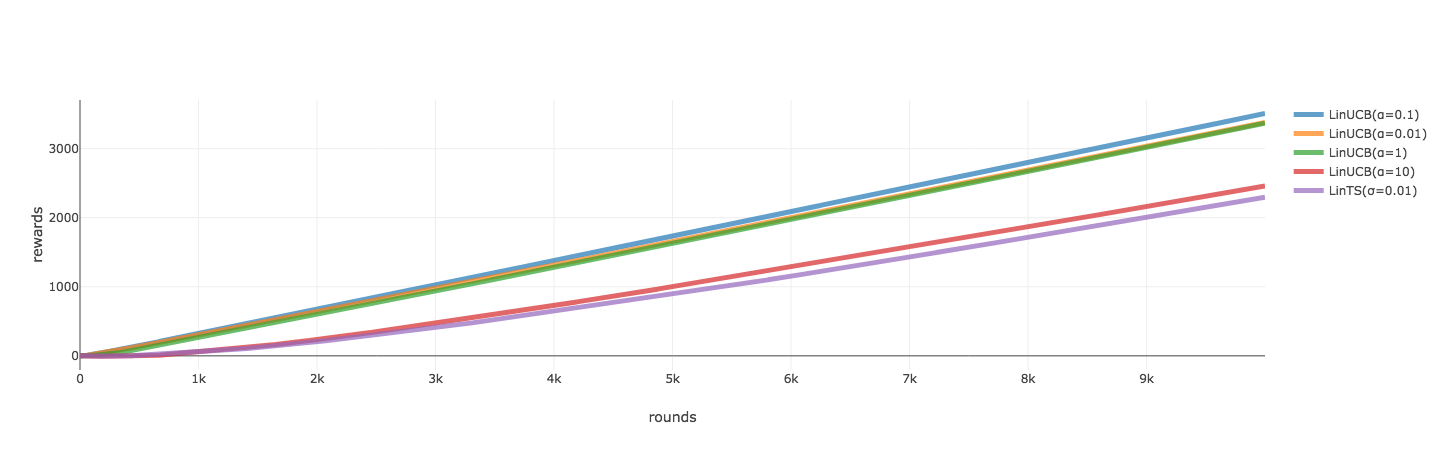

In [14]:
iplot(rewards_plot)

## Plot

In [15]:
true_rewards = np.array([bs.result_list[i].rewards.mean(level="rounds").values[-1] for i in np.arange(len(bs.result_list))]) / n_rounds
estimated_rewards = np.array([df.describe().loc["mean", :].tolist() for df in [result_rm, result_dm]])

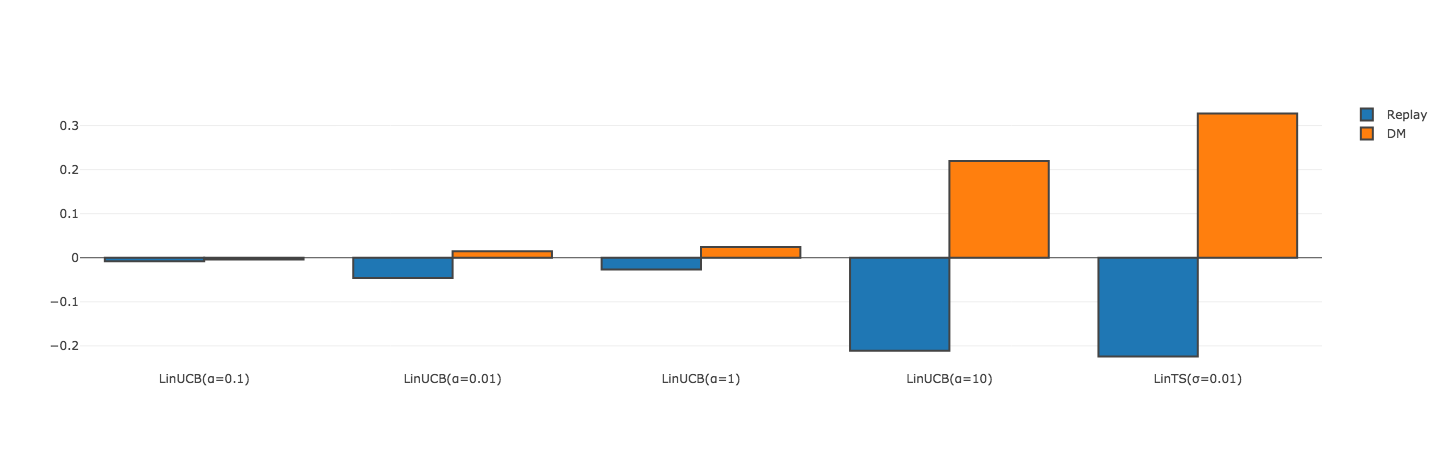

In [17]:
pol_names, est_names = [pol.name for pol in pols], ["Replay", "DM"]
bars = [Bar(x=pol_names, y=(est - true_rewards) / np.abs(true_rewards), marker=dict(line=dict(width=2)), name=est_name) for est, est_name in zip(estimated_rewards, est_names)]
layout = Layout(barmode='group')
fig = Figure(data=bars, layout=layout)
iplot(fig)